# Sensitivity analysis

## What is sensitivity analysis?

Sensitivity analysis is an approach to model analysis which seeks to explore how the model behaviour varies with respect to changes in model parameters.
It can be undertaken with a view to different ideas:
* We may wish to confirm that the parameter values arrived at through calibration are "optimal". Model calibration undertaken via an optimisation seeks to minimise some cost function/error, and in this situation, the introduction of perturbations to these parameter values should result in an increase in this cost function/error - in this situation, sensitivity analysis would consist of instroducing perturbations to the parameter values and exploring how the cost function varies.
* We may wish to explore variable importance. We can compare the extent to which model behaviour changes in response to changes in different parameters values, ranking variables based on which induce the greatest changes in model behaviour. In order to explore this, a cost function/error metric would again be required to quantify the behaviour of the model.
* We may simply wish to explore the model behaviour. We can explore how the model behaviour changes in response to changes in different parameter values; this could be something more visual.

We may wish to divide approaches to sensitivity analysis into two categories: local approaches and global approaches.

Local approaches seek to quantify the impact of small perturbations in model parameters.
A common approach to this is to use a one-factor-at-a-time method (OAT) whereby small perturbations are introduced to one of the model parameters in question whilst keeping all other model parameters the same, allowing us to understand the impact of changes to a model parameter in isolation.
This may, however, overlook interactions between model parameters that may lead to non-linear responses in model behaviour.

Global approaches focus on much larger ranges of parameter values, seeking to explore how the model behaviour varies in response to changes in the model parameters over all parameter space.
Furthermore, this may also explore the response of the system to simultaneous changes in multiple parameter values.

In this specific case, we wish to explore the sensitivity of the model with respect to the following parameters:
* Mean agent speed
* Standard deviation of agent speed
* Agent activation rate

In order to explore the impact of these parameters, we use the following methods:
* Visual methods: Plotting heatmap of agent positions aggregated over all frames to show parts of the model environment that are heavily frequented by agents.
* Numerical methods:
    * Error with respect to maximum number of pedestrians in environment in environment at any given time
    * Error with respect to time taken for all pedestrians to complete their journey
    * Error with respect to the time at which the maximum number of pedestrians in the system at a given time occurs

The visual approach provides us with a qualitative idea of how the model responds to changes in the inputs parameters, whereas the numerical approaches provide us with a quantitative picture.

## Setup

This section seeks to provide the groundwork for the various approaches to sensitivity analysis that will be carried out below.
In short, this means:
* Importing the required packages/modules,
* Defining paths and directories to inputs and outputs,
* Defining any constants that may be used over the course of the analysis,
* Defining any classes that we may require that aren't defined elsewhere, and
* Defining functions that we wish to use.

### Imports

Standard imports:

In [1]:
# System and files
import json
import os
import pickle
import sys
import time
from tqdm import tqdm

# Data handling
import pandas as pd
import numpy as np

# Vis
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Add `stationsim` module to path:

In [2]:
sys.path.append('../../../stationsim/')

Import `stationsim_gcs`:

In [3]:
from stationsim_gcs_model import Model

### Paths and directories

In [4]:
output_data_dir = '../outputs/data/'

In [5]:
fig_dir = '../outputs/figures/sensitivity_analysis/'

In [6]:
model_dir = '../outputs/models/'

### Constants

Observed in the previous notebooks

In [7]:
# Maximum number of pedestrians in the system at any one time
max_n_peds = 85

# Time at which the maximum number of pedestrians in the sytem occurs
t_max_n_peds = 1454

# Time at which all pedestrians have completed their trajectories
end_frame = 5687

Observed in the previous notebook

In [8]:
scaling_factor = 25/14

DEFAULT_SPEED_MEAN = 1.6026400144010877 / scaling_factor
DEFAULT_SPEED_STD = 0.6642343305178546 / scaling_factor
DEFAULT_ACTIVATION_RATE = 1.6

Required for running models and testing the outputs

In [9]:
base_model_params = {'station': 'Grand_Central',
                     'speed_min': 0.31125359137714953 / scaling_factor,
                     'step_limit': 20000,
                     'do_print': False,
                     'pop_total': 274}

In [10]:
data_results = {'n_max_active_pop': max_n_peds,
                't_max_active_pop': t_max_n_peds,
                't_max': end_frame}

### Classes

### Functions

In [11]:
def __get_error(observed, model, variable):
    return observed[variable] - model[variable]

In [12]:
def get_error(observed_results, model_results):
    """
    Calculate errors given model results and results from data.
    """
    n_max_peds = __get_error(observed_results, model_results, 'n_max_active_pop')
    t_max_peds = __get_error(observed_results, model_results, 't_max_active_pop')
    t_max = __get_error(observed_results, model_results, 't_max')
    
    results = {'n_max_active_pop': n_max_peds,
               't_max_active_pop': t_max_peds,
               't_max': t_max}
    return results

In [13]:
def run_model_local(model_params, data_results, var):
    """
    Run model, and collect error outputs.
    """
    
    model = Model(**model_params)

    n_max_active_pop = 0
    t_max_active_pop = 0
    t_max = False

    for _ in range(model.step_limit):
        model.step()

        # Update max_active_pop
        if model.pop_active > n_max_active_pop:
            n_max_active_pop = model.pop_active
            t_max_active_pop = model.step_id

        # get t_max
        if not t_max and model.step_id > 1000 and model.pop_active == 1:
            t_max = model.step_id

    model_results = {'n_max_active_pop': n_max_active_pop,
                     't_max_active_pop': t_max_active_pop,
                     't_max': t_max}

    model_errors = get_error(data_results, model_results)
    model_errors[var] = model_params[var]
    return model_errors

In [14]:
def run_model_global(model_params, data_results):
    model = Model(**model_params)

    n_max_active_pop = 0
    t_max_active_pop = 0
    t_max = False

    for _ in range(model.step_limit):
        model.step()

        # Update max_active_pop
        if model.pop_active > n_max_active_pop:
            n_max_active_pop = model.pop_active
            t_max_active_pop = model.step_id

        # get t_max
        if not t_max and model.step_id > 1000 and model.pop_active == 1:
            t_max = model.step_id

    model_results = {'n_max_active_pop': n_max_active_pop,
                     't_max_active_pop': t_max_active_pop,
                     't_max': t_max}

    model_errors = get_error(data_results, model_results)
    
    parameters = ['birth_rate', 'speed_mean', 'speed_std']
    for param in parameters:
        model_errors[param] = model_params[param]

    return model, model_errors

In [15]:
def output_model(model, model_number, model_dir, batch):
    filepath = f'{model_dir}model_{batch}_{model_number}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

## Local analysis

For this investigation, local sensitivity analysis will take the form of a one-at-a-time (OAT) approach.
This approach consists of identifying the parameters of interest, fixing each of them at the value produced through calibration and perturbing each of them whilst keeping the others constant.
This, in effect, allows us to find
$$\left. \frac{\partial Y}{\partial X} \right|_x$$
where $Y$ is the output variable, $X$ is the parameter and $x$ is the specific value of the parameter that has been chosen.

The parameters of interest for this analysis are
* Activation rate,
* Mean speed,
* Standard deviation of speed.

The calibrated values for each of these parameters, along with the value ranges used for each, are outlined in the table below:

| Variable        |  Calibrated value  | Minimum value | Maximum value | Step size |
|-----------------|:------------------:|:-------------:|:-------------:|:---------:|
| Activation rate |       1.6          |      1.4      |     1.8       |    0.04   |
| Mean speed      | 0.8974784080646091 |      0.78     |     1.00      |    0.022  |
| Std of speed    | 0.3719712250899986 |      0.32     |     0.42      |    0.01   |

* 10 runs per parameter set
* Results should show how output values vary in response to changes in a single parameter
* Run for 10 different values for each parameter
* Series of boxplots/ridgeplot to visualise results

### Activation rate

#### Set up parameter sets

In [13]:
# Activation rates
activation_rates = np.arange(1.4, 1.81, 0.04)

parameter_sets_ar = list()
base_model_params_ar = base_model_params.copy()
base_model_params_ar['speed_mean'] = DEFAULT_SPEED_MEAN
base_model_params_ar['speed_std'] = DEFAULT_SPEED_STD

for activation_rate in activation_rates:
    d = base_model_params_ar.copy()
    d['birth_rate'] = activation_rate
    parameter_sets_ar.append(d)

In [14]:
activation_rates

array([1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 ])

#### Model runs

WARNING: THIS CELL MAY TAKE ~5 HOURS TO RUN.

In [14]:
results_ar = list()

run_per_parameter_set = 10
total_runs = len(parameter_sets_ar) * run_per_parameter_set

i = 1
for parameter_set in tqdm(parameter_sets_ar):
    for _ in range(run_per_parameter_set):
        print(f'Running {i}/{total_runs}')
        model_results = run_model_local(parameter_set, data_results, 'birth_rate')
        results_ar.append(model_results)
        i += 1

Running 1/110
Running 2/110
Running 3/110
Running 4/110
Running 5/110
Running 6/110
Running 7/110
Running 8/110
Running 9/110
Running 10/110
Running 11/110
Running 12/110
Running 13/110
Running 14/110
Running 15/110
Running 16/110
Running 17/110
Running 18/110
Running 19/110
Running 20/110
Running 21/110
Running 22/110
Running 23/110
Running 24/110
Running 25/110
Running 26/110
Running 27/110
Running 28/110
Running 29/110
Running 30/110
Running 31/110
Running 32/110
Running 33/110
Running 34/110
Running 35/110
Running 36/110
Running 37/110
Running 38/110
Running 39/110
Running 40/110
Running 41/110
Running 42/110
Running 43/110
Running 44/110
Running 45/110
Running 46/110
Running 47/110
Running 48/110
Running 49/110
Running 50/110
Running 51/110
Running 52/110
Running 53/110
Running 54/110
Running 55/110
Running 56/110
Running 57/110
Running 58/110
Running 59/110
Running 60/110
Running 61/110
Running 62/110
Running 63/110
Running 64/110
Running 65/110
Running 66/110
Running 67/110
Runn

#### Data handling

Convert to pandas dataframe

In [15]:
results_ar = pd.DataFrame(results_ar)
results_ar.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate
0,5,-2226,-2119,1.4
1,3,-1637,-2854,1.4
2,6,-1851,-2882,1.4
3,13,-851,-3082,1.4
4,7,-3155,-1468,1.4


Write data to csv

In [56]:
results_ar.to_csv(output_data_dir + 'local_ar.csv', index=False)

In [15]:
results_ar = pd.read_csv(output_data_dir + 'local_ar.csv')
results_ar.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate
0,5,-2226,-2119,1.4
1,3,-1637,-2854,1.4
2,6,-1851,-2882,1.4
3,13,-851,-3082,1.4
4,7,-3155,-1468,1.4


#### Visualisation

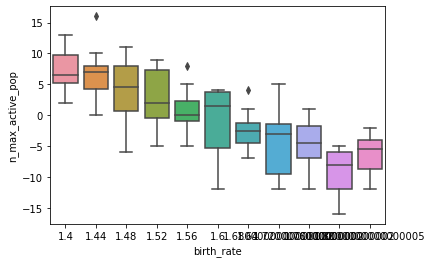

In [16]:
plt.figure()
sns.boxplot(x='birth_rate', y='n_max_active_pop', data=results_ar)
plt.savefig(fig_dir + 'local/ar_n_max_pop.pdf')
plt.show()

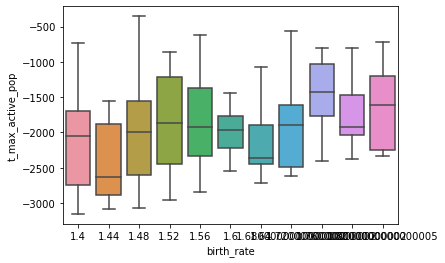

In [17]:
plt.figure()
sns.boxplot(x='birth_rate', y='t_max_active_pop', data=results_ar)
plt.savefig(fig_dir + 'local/ar_t_max_pop.pdf')
plt.show()

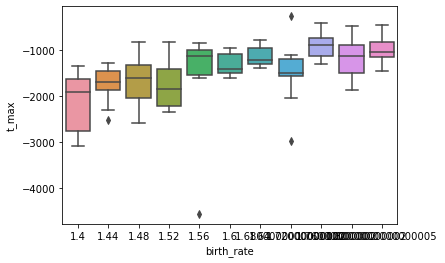

In [18]:
plt.figure()
sns.boxplot(x='birth_rate', y='t_max', data=results_ar)
plt.savefig(fig_dir + 'local/ar_t_max.pdf')
plt.show()

### Mean speed

#### Set up parameter sets

In [19]:
# Mean speed
mean_speeds = np.arange(0.78, 1.01, 0.022)

parameter_sets_ms = list()
base_model_params_ms = base_model_params.copy()
base_model_params_ms['birth_rate'] = DEFAULT_ACTIVATION_RATE
base_model_params_ms['speed_std'] = DEFAULT_SPEED_STD

for mean_speed in mean_speeds:
    d = base_model_params_ms.copy()
    d['speed_mean'] = mean_speed
    for _ in range(10):
        parameter_sets_ms.append(d)

In [20]:
mean_speeds

array([0.78 , 0.802, 0.824, 0.846, 0.868, 0.89 , 0.912, 0.934, 0.956,
       0.978, 1.   ])

#### Model runs

WARNING: THIS CELL MAY TAKE ~5 HOURS TO RUN.

In [40]:
results_ms = list()

for parameter_set in tqdm(parameter_sets_ms):
    model_results = run_model_local(parameter_set, data_results, 'speed_mean')
    results_ms.append(model_results)

100%|██████████| 110/110 [6:02:23<00:00, 197.67s/it] 


#### Data handling

Convert to pandas dataframe

In [41]:
results_ms = pd.DataFrame(results_ms)
results_ms.head()

,n_max_active_pop,t_max_active_pop,t_max,speed_mean
0,-5,-2813,-1520,0.78
1,5,-2204,-1650,0.78
2,6,-641,-1927,0.78
3,-3,-2797,-1730,0.78
4,2,-1579,-3858,0.78


Write data to csv

In [58]:
results_ms.to_csv(output_data_dir + 'local_ms.csv', index=False)

In [21]:
results_ms = pd.read_csv(output_data_dir + 'local_ms.csv')
results_ms.head()

,n_max_active_pop,t_max_active_pop,t_max,speed_mean
0,-5,-2813,-1520,0.78
1,5,-2204,-1650,0.78
2,6,-641,-1927,0.78
3,-3,-2797,-1730,0.78
4,2,-1579,-3858,0.78


#### Visualisation

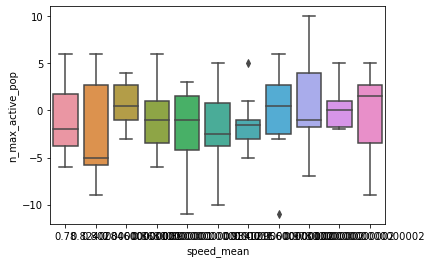

In [22]:
plt.figure()
sns.boxplot(x='speed_mean', y='n_max_active_pop', data=results_ms)
plt.savefig(fig_dir + 'local/ms_n_max_pop.pdf')
plt.show()

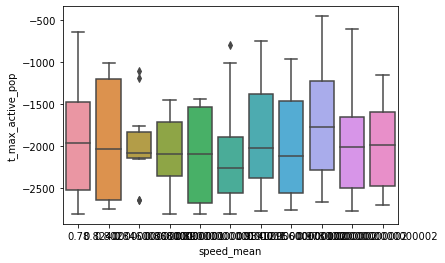

In [23]:
plt.figure()
sns.boxplot(x='speed_mean', y='t_max_active_pop', data=results_ms)
plt.savefig(fig_dir + 'local/ms_t_max_pop.pdf')
plt.show()

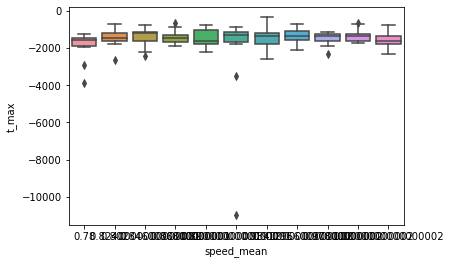

In [24]:
plt.figure()
sns.boxplot(x='speed_mean', y='t_max', data=results_ms)
plt.savefig(fig_dir + 'local/ms_t_max.pdf')
plt.show()

### std speed

#### Set up parameter sets

In [25]:
# std speed
std_speeds = np.arange(0.32, 0.421, 0.01)

parameter_sets_ss = list()
base_model_params_ss = base_model_params.copy()
base_model_params_ss['birth_rate'] = DEFAULT_ACTIVATION_RATE
base_model_params_ss['speed_mean'] = DEFAULT_SPEED_MEAN

for std_speed in std_speeds:
    d = base_model_params_ss.copy()
    d['speed_std'] = std_speed
    for _ in range(10):
        parameter_sets_ss.append(d)

In [26]:
std_speeds

array([0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42])

#### Model runs

WARNING: THIS CELL MAY TAKE ~5 HOURS TO RUN.

In [48]:
results_ss = list()

for parameter_set in tqdm(parameter_sets_ss):
    model_results = run_model_local(parameter_set, data_results, 'speed_std')
    results_ss.append(model_results)

100%|██████████| 110/110 [6:59:32<00:00, 228.84s/it]   


#### Data handling

Convert to pandas dataframe

In [49]:
results_ss = pd.DataFrame(results_ss)
results_ss.head()

,n_max_active_pop,t_max_active_pop,t_max,speed_std
0,7,-2766,-1895,0.32
1,-2,-2094,-1057,0.32
2,2,-2813,-2010,0.32
3,4,-2063,-1223,0.32
4,2,-985,-1575,0.32


Write data to csv

In [60]:
results_ss.to_csv(output_data_dir + 'local_ss.csv', index=False)

In [27]:
results_ss = pd.read_csv(output_data_dir + 'local_ss.csv')
results_ss.head()

,n_max_active_pop,t_max_active_pop,t_max,speed_std
0,7,-2766,-1895,0.32
1,-2,-2094,-1057,0.32
2,2,-2813,-2010,0.32
3,4,-2063,-1223,0.32
4,2,-985,-1575,0.32


#### Visualisation

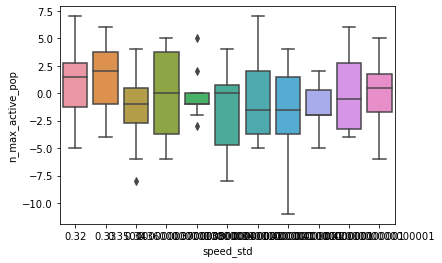

In [28]:
plt.figure()
sns.boxplot(x='speed_std', y='n_max_active_pop', data=results_ss)
plt.savefig(fig_dir + 'local/ss_n_max_pop.pdf')
plt.show()

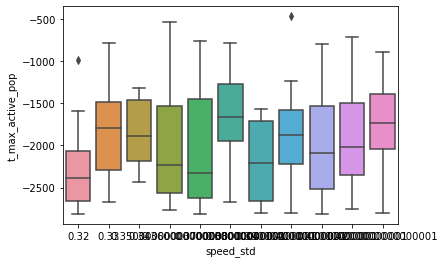

In [29]:
plt.figure()
sns.boxplot(x='speed_std', y='t_max_active_pop', data=results_ss)
plt.savefig(fig_dir + 'local/ss_t_max_pop.pdf')
plt.show()

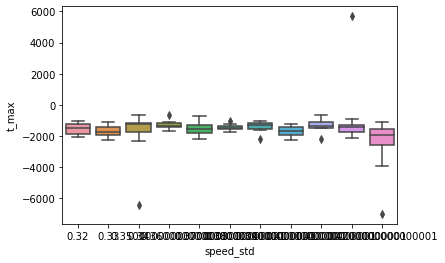

In [30]:
plt.figure()
sns.boxplot(x='speed_std', y='t_max', data=results_ss)
plt.savefig(fig_dir + 'local/ss_t_max.pdf')
plt.show()

## Global analysis

In this section, we undertake a global sensitivity analysis via two approaches: a regression-based approach and a visualisation-based approach.

In the regression-based approach, we seek to fit a regression model for which we consider the following input variables:
* Mean agent speed,
* Standard deviation of agent speed,
* Agent activation rate,

and the following output variables:
* Error with respect to maximum number of pedestrians in environment in environment at any given time,
* Error with respect to time taken for all pedestrians to complete their journey,
* Error with respect to the time at which the maximum number of pedestrians in the system at a given time occurs.

This will give us a quanititative picture of how each of these response variables varies with respect to each of the model parameters outlined above, as well as how interactions between these variables may impact the response variables.

In the visualisation approach, we seek to visualise how the behaviour of the model varies with respect to changes in each of the model parameters.
These visualisations will take the form of heatmaps which detail the frequency with which different sections of the model environment are visited by pedestrians.

In order to apply each of these approaches, the model is run 5 times with the following ranges of paramter values:

| Variable        |  Calibrated value  | Minimum value | Maximum value |
|-----------------|:------------------:|:-------------:|:-------------:|
| Activation rate |       1.6          |      1.0      |     2.0       |
| Mean speed      | 0.8974784080646091 |      0.5      |     1.5       |
| Std of speed    | 0.3719712250899986 |      0.2      |     1.0       |

### Set up parameter sets

In [16]:
activation_rate_max = 2
activation_rate_min = 1

In [17]:
mean_speed_max = 1.5
mean_speed_min = 0.5

In [18]:
std_speed_max = 1
std_speed_min = 0.2

In [19]:
parameter_sets = list()
np.random.seed(666)
n_runs = 200

for _ in range(n_runs):
    mean_speed = np.random.uniform(mean_speed_min, mean_speed_max)
    std_speed = np.random.uniform(std_speed_min, std_speed_max)
    activation_rate = np.random.uniform(activation_rate_min, activation_rate_max)
    d = base_model_params.copy()
    d['speed_mean'] = mean_speed
    d['speed_std'] = std_speed
    d['birth_rate'] = activation_rate        
    parameter_sets.append(d)

In [20]:
df = pd.DataFrame(parameter_sets)
df.head()

,station,speed_min,step_limit,do_print,pop_total,speed_mean,speed_std,birth_rate
0,Grand_Central,0.174302,20000,False,274,1.200437,0.875349,1.676514
1,Grand_Central,0.174302,20000,False,274,1.227858,0.961166,1.012703
2,Grand_Central,0.174302,20000,False,274,0.913588,0.239050,1.099929
3,Grand_Central,0.174302,20000,False,274,1.008066,0.360198,1.744154
4,Grand_Central,0.174302,20000,False,274,0.692892,0.760676,1.293228


Plot the distriubtion of each of the parameters of interest:

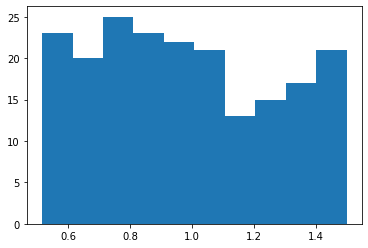

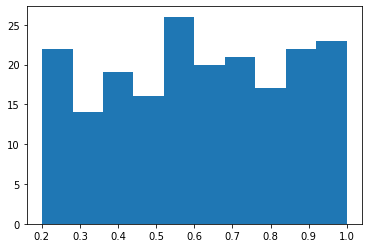

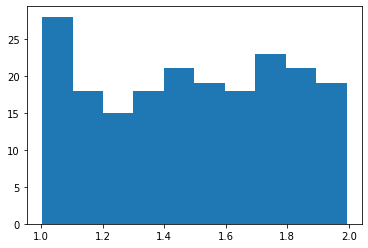

In [21]:
parameters = ['speed_mean', 'speed_std', 'birth_rate']

for param in parameters:
    plt.figure()
    plt.hist(df[param])
    plt.show()

Check for any correlation between the parameters of interest:

In [22]:
tdf = df.loc[:, parameters]
tdf.corr()

,speed_mean,speed_std,birth_rate
speed_mean,1.000000,0.008274,0.010753
speed_std,0.008274,1.000000,0.007947
birth_rate,0.010753,0.007947,1.000000


Split the runs into two batches:

In [23]:
midpoint = n_runs // 2
parameter_sets_1 = parameter_sets[: midpoint]
parameter_sets_2 = parameter_sets[midpoint :]
print(len(parameter_sets_1), len(parameter_sets_2))

100 100


### Runs

Set up containers:

In [26]:
global_results_1 = list()
global_results_2 = list()

Run first batch:

In [27]:
i = 0
for parameter_set in tqdm(parameter_sets_1):
    if i % 20 == 11:
        time.sleep(30)
    model, results = run_model_global(parameter_set, data_results)
    global_results_1.append(results)
    
    output_model(model, i, model_dir, 1)
    i += 1

100%|██████████| 100/100 [9:10:35<00:00, 330.35s/it] 


Convert the results to a dataframe and write to csv:

In [28]:
global_results_1 = pd.DataFrame(global_results_1)
global_results_1.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-2,-1918,-1347,1.676514,1.200437,0.875349
1,28,-5262,-2986,1.012703,1.227858,0.961166
2,26,-1366,-2947,1.099929,0.913588,0.239050
3,0,-1644,-961,1.744154,1.008066,0.360198
4,15,-674,-1626,1.293228,0.692892,0.760676


In [29]:
global_results_1.to_csv(output_data_dir + 'global_errors_1.csv', index=False)

Run second batch:

In [30]:
i = 0
for parameter_set in tqdm(parameter_sets_2):
    if i % 20 == 11:
        time.sleep(60)
    model, results = run_model_global(parameter_set, data_results)
    global_results_2.append(results)
    
    output_model(model, i, model_dir, 2)
    i += 1

100%|██████████| 100/100 [6:09:58<00:00, 221.98s/it] 


Convert the results to a dataframe and write to csv:

In [31]:
global_results_2 = pd.DataFrame(global_results_2)
global_results_2.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-5,-1200,-1536,1.649283,0.708949,0.206626
1,6,-1934,-1567,1.439688,1.282874,0.284804
2,-5,-2430,-929,1.648376,0.591670,0.369886
3,19,-3018,-2677,1.129597,1.101797,0.574736
4,-19,-1243,-929,1.947473,0.746014,0.821157


In [32]:
global_results_2.to_csv(output_data_dir + 'global_errors_2.csv', index=False)

#### Read data back in

Read in csv:

In [16]:
global_results_1 = pd.read_csv(output_data_dir + 'global_errors_1.csv')
global_results_1.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-2,-1918,-1347,1.676514,1.200437,0.875349
1,28,-5262,-2986,1.012703,1.227858,0.961166
2,26,-1366,-2947,1.099929,0.913588,0.239050
3,0,-1644,-961,1.744154,1.008066,0.360198
4,15,-674,-1626,1.293228,0.692892,0.760676


In [17]:
global_results_2 = pd.read_csv(output_data_dir + 'global_errors_2.csv')
global_results_2.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-5,-1200,-1536,1.649283,0.708949,0.206626
1,6,-1934,-1567,1.439688,1.282874,0.284804
2,-5,-2430,-929,1.648376,0.591670,0.369886
3,19,-3018,-2677,1.129597,1.101797,0.574736
4,-19,-1243,-929,1.947473,0.746014,0.821157


In [18]:
global_results = pd.concat([global_results_1, global_results_2])
global_results.head()

,n_max_active_pop,t_max_active_pop,t_max,birth_rate,speed_mean,speed_std
0,-2,-1918,-1347,1.676514,1.200437,0.875349
1,28,-5262,-2986,1.012703,1.227858,0.961166
2,26,-1366,-2947,1.099929,0.913588,0.239050
3,0,-1644,-961,1.744154,1.008066,0.360198
4,15,-674,-1626,1.293228,0.692892,0.760676


In [19]:
print(global_results_1.shape, global_results_2.shape, global_results.shape)

(100, 6) (100, 6) (200, 6)


### Regression setup

In [20]:
import statsmodels.api as sm

### Regression: Maximum number of pedestrians in environment

In [21]:
predictor_vars = ['birth_rate', 'speed_mean', 'speed_std']
response_var = ['n_max_active_pop']

In [22]:
Y = global_results.loc[:, response_var]
X = global_results.loc[:, predictor_vars]
X = sm.add_constant(X)

In [23]:
print(X.shape)

(200, 4)


In [24]:
print(Y.shape)

(200, 1)


In [25]:
ols = sm.OLS(Y, X).fit()

In [26]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       n_max_active_pop   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     719.7
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          1.65e-105
Time:                        13:53:31   Log-Likelihood:                -574.04
No. Observations:                 200   AIC:                             1156.
Df Residuals:                     196   BIC:                             1169.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.5287      2.036     31.692      0.000      60.513      68.544
birth_rate   -47.0461      1.035    -45.453      0.000     -49.087     -45.005
speed_mean    10.7265      1.060     10.124      0.000       8.637      12.816
speed_std     -0.0905      1.321     -0.069      0.945      -2.695       2.514
==============================================================================
Omnibus:                        3.440   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.634
Skew:                           0.125   Prob(JB):                        0.163
Kurtosis:                       3.611   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

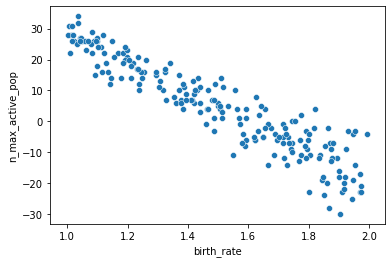

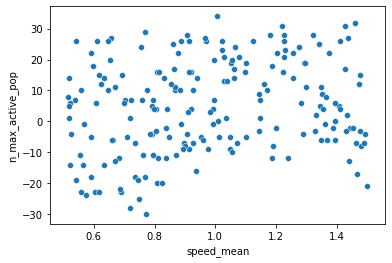

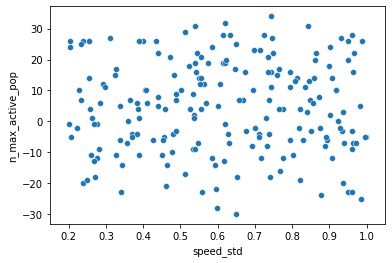

In [27]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_n_max_pop.pdf')
    plt.show()

### Regression: Time of maximum number of pedestrians

In [28]:
response_var = ['t_max_active_pop']

In [29]:
Y = global_results.loc[:, response_var]

In [30]:
ols = sm.OLS(Y, X).fit()

In [31]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       t_max_active_pop   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     23.04
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           8.08e-13
Time:                        13:53:32   Log-Likelihood:                -1628.2
No. Observations:                 200   AIC:                             3264.
Df Residuals:                     196   BIC:                             3278.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4198.7089    396.164    -10.598      0.000   -4980.001   -3417.417
birth_rate  1617.3883    201.387      8.031      0.000    1220.224    2014.552
speed_mean  -445.8812    206.147     -2.163      0.032    -852.433     -39.329
speed_std    130.0261    256.983      0.506      0.613    -376.781     636.833
==============================================================================
Omnibus:                        0.282   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.128
Skew:                           0.053   Prob(JB):                        0.938
Kurtosis:                       3.063   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

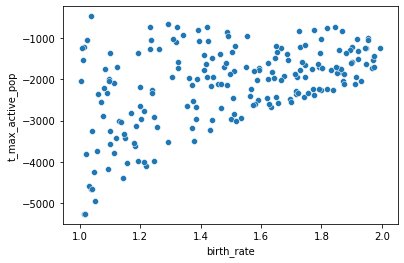

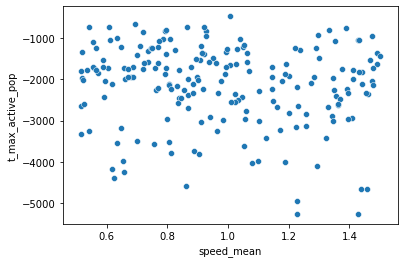

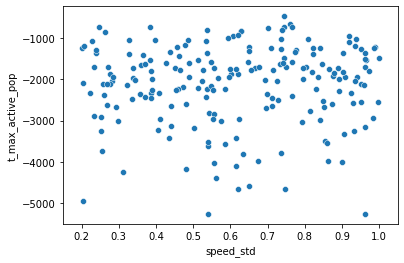

In [32]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_t_max_pop.pdf')
    plt.show()

### Regression: Time of completion

In [33]:
response_var = ['t_max']

In [34]:
Y = global_results.loc[:, response_var]

In [35]:
ols = sm.OLS(Y, X).fit()

In [36]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  t_max   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     233.4
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           1.97e-64
Time:                        13:53:32   Log-Likelihood:                -1510.9
No. Observations:                 200   AIC:                             3030.
Df Residuals:                     196   BIC:                             3043.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6415.5400    220.373    -29.112      0.000   -6850.147   -5980.933
birth_rate  2942.8234    112.025     26.269      0.000    2721.894    3163.752
speed_mean   292.8607    114.673      2.554      0.011      66.709     519.012
speed_std   -246.0445    142.951     -1.721      0.087    -527.964      35.875
==============================================================================
Omnibus:                       32.723   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.180
Skew:                          -0.872   Prob(JB):                     1.72e-12
Kurtosis:                       4.860   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

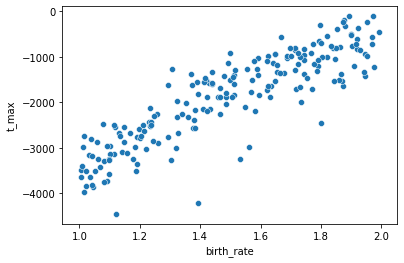

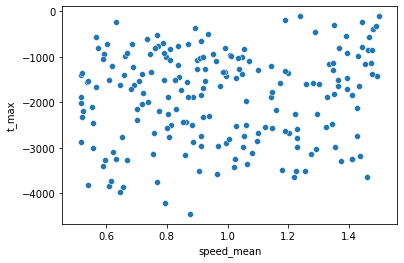

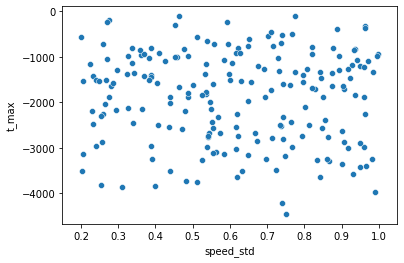

In [37]:
for predictor_var in predictor_vars:
    plt.figure()
    sns.scatterplot(x=predictor_var, y=response_var[0], data=global_results)
    plt.savefig(fig_dir + f'global/{predictor_var}_t_max.pdf')
    plt.show()

### Visualisations

Read in model pickles:

In [ ]:
agent_data = list()

for filename in tqdm(os.listdir(model_dir)):
    full_filename = model_dir + filename
    with open(full_filename, 'rb') as f:
        model = pickle.load(f)
    agent_data.append(model.history_state)

print(len(agent_data))

 38%|███▊      | 77/200 [01:03<01:20,  1.54it/s]